# Claude Sonnet 3.5 V2 with v2.14 prompt

This notebook outlines the steps undertook to generate a prediction using Claude Sonnet 3.5 V2 with prompt from 2/14/25.

This prompt is built from the v2.13 version by adding additional instructions based on analysis of failed predictions, and incorporate [plan-write-and-revise](https://aclanthology.org/N19-4016/) logic. Since the two examples used in the few-shots prompts were direct excerpts from the test data, to reduce leakage, used GPT-4o to paraphrase these two examples and replaced them with the paraphrased examples.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from prediction_utils import predict
from evaluate_predictions import show_metrics

from instructions import claude_instructions_v214
MODEL_ID = "anthropic.claude-3-5-sonnet-20241022-v2:"
SYSTEM_PROMPT = claude_instructions_v214

# Load the data

In [2]:
df = pd.read_csv("data/dataset.csv")
df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN


# Use the model to generation predictions

In [3]:
%%time
predictions = predict(df, MODEL_ID, SYSTEM_PROMPT)
predictions[:2]

INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 2
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 4
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241

CPU times: user 51.6 s, sys: 6.92 s, total: 58.5 s
Wall time: 31min 53s


[{'0003.91306_cites_87633.txt': {'model': 'claude-3-5-sonnet-20241022',
   'input_tokens': 2675,
   'output_tokens': 119,
   'prediction': 'no',
   'confidence': 0.95,
   'rationale': "The passage does not show any Explicit or Implicit Negative Actions by the Acting Case to overrule the Target Case. Instead, the Target Case's rules about purchasers of coupon bonds are 'repeated and reaffirmed' by the Acting Case. The passage merely discusses how these rules apply differently to matured versus non-matured obligations, but does not overrule the original precedent.",
   'raw_results': '{\n  "overruled": "no",\n  "confidence": 0.95,\n  "rationale": "The passage does not show any Explicit or Implicit Negative Actions by the Acting Case to overrule the Target Case. Instead, the Target Case\'s rules about purchasers of coupon bonds are \'repeated and reaffirmed\' by the Acting Case. The passage merely discusses how these rules apply differently to matured versus non-matured obligations, but d

In [5]:
prediction_df = pd.DataFrame([
    {"filename": filename, **details} 
    for prediction in predictions 
    for filename, details in prediction.items()
])
prediction_df.head()

,filename,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0003.91306_cites_87633.txt,claude-3-5-sonnet-20241022,2675,119,no,0.95,The passage does not show any Explicit or Impl...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
1,0005.91306_cites_88693.txt,claude-3-5-sonnet-20241022,2646,135,no,0.95,The passage discusses the Target Case (Hunting...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
2,0004.91306_cites_88240.txt,claude-3-5-sonnet-20241022,2641,341,no,0.95,The passage shows that the Target Case (Texas ...,Let me analyze this according to the given ins...
3,0002.91306_cites_88994.txt,claude-3-5-sonnet-20241022,3158,386,no,0.95,The passages discuss the Target Case in detail...,Let me analyze this according to the instructi...
4,0001.91306_cites_88061.txt,claude-3-5-sonnet-20241022,3477,371,yes,0.95,The passage explicitly states that a key posit...,Let me analyze this carefully following the in...


## Save the raw prediction results

In [6]:
prediction_df.to_csv("predictions/1.claude/3.sonnet3.5v2_v214_prompt.csv", index=False)

## Check if any datapoints did not get prediction results and need to be re-predicted or cleaned

In [7]:
prediction_df["prediction"].isna().sum()

0

In [8]:
# Here I manually reviewed these cases in Google Sheets and replaced with the cleaned version
#prediction_df = pd.read_csv("predictions/1.claude/3.sonnet3.5v2_v214_prompt.csv")

In [8]:
prediction_df["prediction"].isna().sum()

0

# Combine the prediction results with label for evaluation

In [8]:
assert len(df) == len(prediction_df)

In [9]:
eval_df = df.merge(prediction_df, how="left", on="filename")
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-sonnet-20241022,3477,371,yes,0.95,The passage explicitly states that a key posit...,Let me analyze this carefully following the in...
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-sonnet-20241022,3158,386,no,0.95,The passages discuss the Target Case in detail...,Let me analyze this according to the instructi...
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-sonnet-20241022,2675,119,no,0.95,The passage does not show any Explicit or Impl...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-sonnet-20241022,2641,341,no,0.95,The passage shows that the Target Case (Texas ...,Let me analyze this according to the given ins...
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-sonnet-20241022,2646,135,no,0.95,The passage discusses the Target Case (Hunting...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."


# Run evaluation

In [10]:
df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [11]:
eval_df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [12]:
eval_df["prediction"].value_counts()

prediction
no     927
yes    157
Name: count, dtype: int64

In [13]:
eval_df["input_tokens"].sum()

4204378

In [14]:
eval_df["output_tokens"].sum()

347006

In [15]:
y_true = eval_df["overruled"].map({"yes": 1, "no": 0})
y_pred = eval_df["prediction"].map({"yes": 1, "no": 0, "partially": 1})

In [16]:
report = classification_report(y_true, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.96      0.95      0.96       935
         Yes       0.71      0.75      0.73       149

    accuracy                           0.92      1084
   macro avg       0.84      0.85      0.84      1084
weighted avg       0.93      0.92      0.93      1084



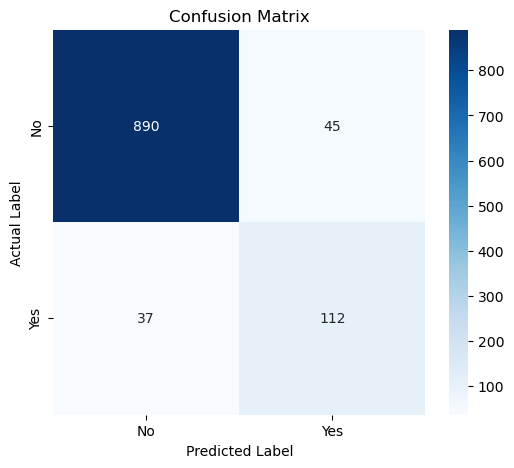

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
show_metrics(cm, y_true)

precision: of all predicted positives, how many were actual positives
recall: of all actual positives, how many we predicted to be positives
---------
METRICS
Accuracy: 0.92
Precision: 0.71
Recall: 0.75
F-score: 0.73
Specificity: 0.95
---------
DATASET
Total Responses: 1084
Total Positives: 149
Total Negatives: 935
---------
RECOUNT
True positives: 112
True negatives: 890
False positives: 45
False negatives: 37


In [19]:
confidently_wrong_positive = (eval_df["prediction"] == "yes") & (eval_df["overruled"] == "no") & (eval_df["confidence"] >= 0.8)
confidently_wrong_positive.sum()

45

In [20]:
confidently_wrong_negative = (eval_df["prediction"] == "no") & (eval_df["overruled"] == "yes") & (eval_df["confidence"] >= 0.8)
confidently_wrong_negative.sum()

35

# Save the evaluation df

In [21]:
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-sonnet-20241022,3477,371,yes,0.95,The passage explicitly states that a key posit...,Let me analyze this carefully following the in...
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-sonnet-20241022,3158,386,no,0.95,The passages discuss the Target Case in detail...,Let me analyze this according to the instructi...
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-sonnet-20241022,2675,119,no,0.95,The passage does not show any Explicit or Impl...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-sonnet-20241022,2641,341,no,0.95,The passage shows that the Target Case (Texas ...,Let me analyze this according to the given ins...
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-sonnet-20241022,2646,135,no,0.95,The passage discusses the Target Case (Hunting...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."


In [22]:
eval_df.to_csv("predictions/1.claude/3.sonnet3.5v2_v214_prompt_eval.csv", index=False)